# <center>Predicting Sales</center>
<a><b>Problem Statement</b> -- Predicting the sales of products across stores of a retail chain
A large Indian retail chain has stores across 3 states in India: Maharashtra, Telangana and 
Kerala. These stores stock products across various categories such as FMCG (fast moving 
consumer goods), eatables / perishables and others. Managing the inventory is crucial for 
the revenue stream of the retail chain. Meeting the demand is important to not lose 
potential revenue, while at the same time stocking excessive products could lead to losses.</a> 

<a>The datasets are provided as cited below: <br>
<b>Target attribute:</b> "sales" (continuous)<br>
train_data.csv:<br>
! date : The date for which the observation was recorded
! product_identifier : The id for a product<br>
! department_identifier : The id for a specific department in a store<br>
! category_of_product : The category to which a product belongs <br>
! outlet : The id for a store <br>
! state : The name of the state <br>
! sales : The number of sales for the product <br>
<b>product_prices.csv:</b> The prices of products at each store for each week<br>
! date_to_week_id_map.csv : The mapping from a date to the week_id<br>
! sample_submission.csv : The format for submissions<br>
<b>● The test_data.csv file has all the attributes of the train_data.csv file excluding the sales (target) column</b></a>

In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.svm import SVR

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('train_data.csv')
df_pp = pd.read_csv('product_prices.csv')
df_dw = pd.read_csv('date_to_week_id_map.csv')

In [3]:
df_train.head()

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales
0,2012-01-01,74,11,others,111,Maharashtra,0
1,2012-01-01,337,11,others,111,Maharashtra,1
2,2012-01-01,423,12,others,111,Maharashtra,0
3,2012-01-01,432,12,others,111,Maharashtra,0
4,2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0


In [6]:
df_temp = df_dw.merge(df_pp, on = "week_id", how = "inner")
df_temp.head()

,date,week_id,outlet,product_identifier,sell_price
0,2012-01-01,49,111,74,2.94
1,2012-01-01,49,111,337,7.44
2,2012-01-01,49,111,423,0.97
3,2012-01-01,49,111,432,4.97
4,2012-01-01,49,111,581,4.88


In [7]:
df_temp.shape

(410500, 5)

In [8]:
df=pd.merge(df_train, df_temp, on =['date','product_identifier','outlet'],how = "inner")
df.head()

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price
0,2012-01-01,74,11,others,111,Maharashtra,0,49,2.94
1,2012-01-01,337,11,others,111,Maharashtra,1,49,7.44
2,2012-01-01,423,12,others,111,Maharashtra,0,49,0.97
3,2012-01-01,432,12,others,111,Maharashtra,0,49,4.97
4,2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0,49,4.88


In [9]:
df.shape

(395000, 9)

# <center>checking for null values</center>

In [10]:
df.isnull().sum().sum()

0

# <center>checking for duplicates</center>

In [11]:
df.duplicated().sum()

0

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395000 entries, 0 to 394999
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   date                   395000 non-null  object 
 1   product_identifier     395000 non-null  int64  
 2   department_identifier  395000 non-null  int64  
 3   category_of_product    395000 non-null  object 
 4   outlet                 395000 non-null  int64  
 5   state                  395000 non-null  object 
 6   sales                  395000 non-null  int64  
 7   week_id                395000 non-null  int64  
 8   sell_price             395000 non-null  float64
dtypes: float64(1), int64(5), object(3)
memory usage: 30.1+ MB


In [13]:
df.describe(include='all')

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price
count,395000,395000.000000,395000.000000,395000,395000.000000,395000,395000.000000,395000.000000,395000.000000
unique,790,NaN,NaN,3,NaN,3,NaN,NaN,NaN
top,2012-01-01,NaN,NaN,fast_moving_consumer_goods,NaN,Maharashtra,NaN,NaN,NaN
freq,500,NaN,NaN,229100,NaN,158000,NaN,NaN,NaN
mean,NaN,1509.960000,24.460000,NaN,211.200000,NaN,1.228919,105.070886,4.987644
std,NaN,809.799518,6.337863,NaN,91.161291,NaN,3.595266,32.578749,3.874444
min,NaN,74.000000,11.000000,NaN,111.000000,NaN,0.000000,49.000000,0.050000
25%,NaN,926.000000,21.000000,NaN,113.000000,NaN,0.000000,77.000000,2.680000
50%,NaN,1325.000000,22.000000,NaN,221.500000,NaN,0.000000,105.000000,3.980000
75%,NaN,1753.000000,31.000000,NaN,331.000000,NaN,1.000000,133.000000,6.480000


### <center>since there is no much difference between mean and median values for each continous feature there seems to be no outliers in the data.</center>

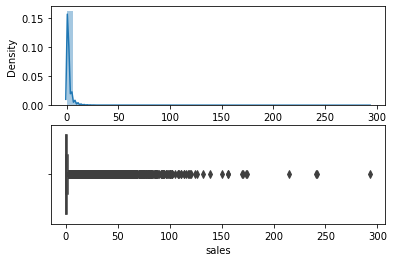

In [14]:
# checking for outliers for sales to be sure as there is some difference b/w man and median for that feature
fig,ax1 = plt.subplots(2,1)
sns.distplot(df['sales'],ax=ax1[0])
sns.boxplot(df['sales'],ax=ax1[1])
plt.show()

In [15]:
# outlier Treament for sales feature -- imputing median value where value value is greater than equal to 150.
df['sales']=np.where(df['sales']>=150,df['sales'].median(),df['sales'])

# <center>Exploratory Data Analysis</center>

<AxesSubplot:xlabel='sales', ylabel='category_of_product'>

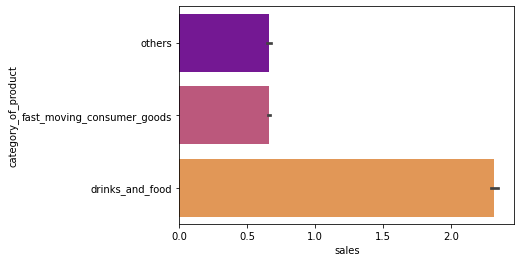

In [16]:
sns.barplot(x ='sales', y ='category_of_product', data = df,palette ='plasma')

In [17]:
df['category_of_product'].value_counts()

fast_moving_consumer_goods    229100
drinks_and_food               134300
others                         31600
Name: category_of_product, dtype: int64

<AxesSubplot:xlabel='sales', ylabel='state'>

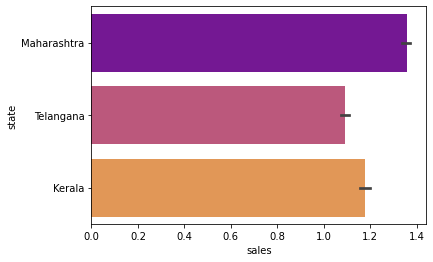

In [18]:
sns.barplot(x ='sales', y ='state', data = df,palette ='plasma')

### <center> from above figure we can conclude that <b>drinks and foods</b> have a higher sales than other two categories and we can conclude that in <b>kerala</b> we get more sales followed by <b>Maharashtra and Telengana</b></center>

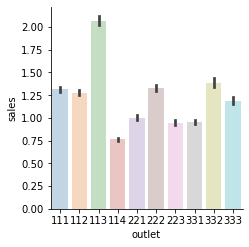

In [19]:
sns.PairGrid(df,y_vars='sales',x_vars='outlet',height = 3.5).map(sns.barplot, alpha = 0.3)
plt.show()

Here we can observe that outlet 113 has greater number of sales followed by 332 and so on compared to other outlets.

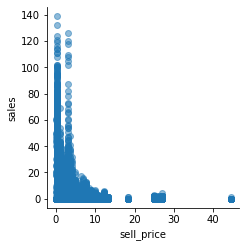

In [21]:
sns.PairGrid(df,y_vars='sales',x_vars='sell_price',height = 3.5).map(plt.scatter, alpha = 0.5)
plt.show()

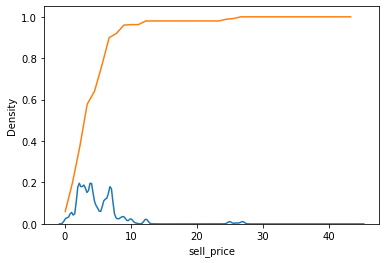

In [27]:
#CDF
values, base = np.histogram(df['sell_price'], bins=40, density=True)

pdf = values/(sum(values))
cumulative = np.cumsum(values)

cdf = np.cumsum(pdf)
sns.kdeplot(df['sell_price'])
plt.plot(base[:-1],cdf)

plt.show()

### <center>we can obeserve approximatly 95% of sell price lies below 15, and we can also observe that for less sell_price we have most of the sales when sell_price is less than 15</center>

# <center>Feature Engineering</center>

In [23]:
df['year'] = df['date'].apply(lambda x: int(x.split('-')[0]))
df['month'] = df['date'].apply(lambda x: int(x.split('-')[1]))
df['days'] = df['date'].apply(lambda x: int(x.split('-')[2]))

In [24]:
df.drop('date',axis=1,inplace=True)

In [25]:
df['state'].unique()

array(['Maharashtra', 'Telangana', 'Kerala'], dtype=object)

In [39]:
#Labelencoder
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()

df_cp=labelencoder.fit(df['category_of_product'])
df['category_of_product'] = df_cp.transform(df['category_of_product'])
df_st=labelencoder.fit(df['state'])
df['state'] = df_st.transform(df['state'])

In [40]:
df.head()

,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price,year,month,days
0,74,11,2,111,1,0.0,49,2.94,2012,1,1
1,337,11,2,111,1,1.0,49,7.44,2012,1,1
2,423,12,2,111,1,0.0,49,0.97,2012,1,1
3,432,12,2,111,1,0.0,49,4.97,2012,1,1
4,581,21,1,111,1,0.0,49,4.88,2012,1,1


# <center>Train Test Split</center>

In [41]:
x = df.drop('sales',axis=1)
y = df['sales']

In [42]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=42)
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,test_size=0.20,random_state=42)

# <center>Model Building and tunning the model</center>

In [161]:
regr = DecisionTreeRegressor()
regr.fit(x_train, y_train)
regr.score(x_test,y_test)

0.09099265071083162

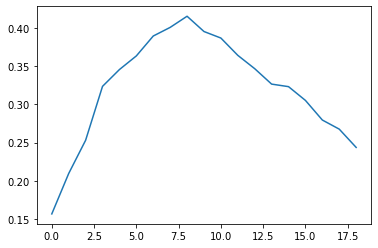

In [162]:
acc = []
for i in range(1,20):
    regr = DecisionTreeRegressor(max_depth=i)
    regr.fit(x_train, y_train)
    acc.append(regr.score(x_cv,y_cv))
plt.plot(acc)

By performing the cross validation here i am able to find the best hyperparameter and avoid the model from overfitting and underfitting

In [163]:
np.argmax(acc),acc[np.argmax(acc)]

(8, 0.41513253013864637)

In [164]:
regr = DecisionTreeRegressor(max_depth=8)
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)
regr.score(x_test,y_test)

0.3969661081977097

In [165]:
mean_squared_error(y_test, y_pred,squared=False)

2.6372206913969527

<AxesSubplot:xlabel='sales', ylabel='Density'>

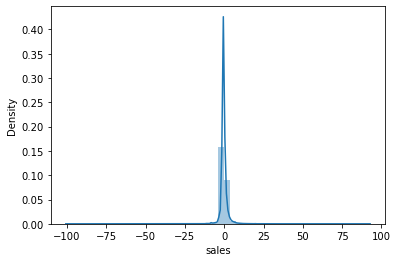

In [166]:
#plot error
sns.distplot(y_test-y_pred)

In [167]:
r2_score(y_test, y_pred)

0.3969661081977097

# <center>Random Forest Regressor</center>

In [168]:
regr = RandomForestRegressor()
regr.fit(x_train, y_train)
regr.score(x_test,y_test)

0.4596673031028773

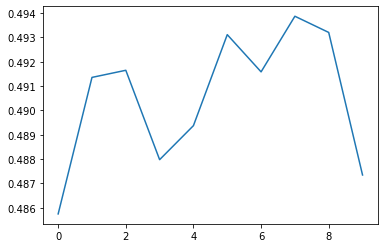

In [169]:
acc = []
for i in range(100,200,10):
    regr = RandomForestRegressor(n_estimators =i)
    regr.fit(x_train, y_train)
    acc.append(regr.score(x_cv,y_cv))
plt.plot(acc)

In [170]:
np.argmax(acc),acc[np.argmax(acc)]

(7, 0.49387327578711104)

# <center>training again with best estimators / hyperparameter</center>

In [171]:
regr = RandomForestRegressor(n_estimators=170)
regr.fit(x_train, y_train)
print(regr.score(x_test,y_test))
regr.predict(x_test)

0.4599205150417961


array([1.17647059e-02, 5.35294118e-01, 1.66470588e+00, ...,
       4.11764706e-01, 7.05882353e-01, 1.22058824e+01])

In [172]:
print('RMSE :',mean_squared_error(y_test, y_pred,squared=False))
print('r2 score: ', r2_score(y_test, y_pred))

RMSE : 2.6372206913969527
r2 score:  0.3969661081977097


<AxesSubplot:xlabel='sales', ylabel='Density'>

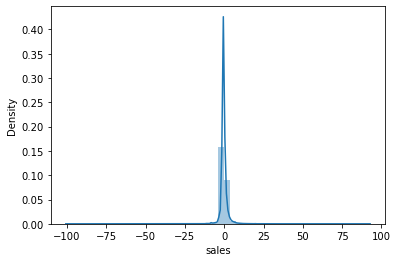

In [173]:
#plot error
sns.distplot(y_test-y_pred)

# <center>Checking for multicollinearity</center>

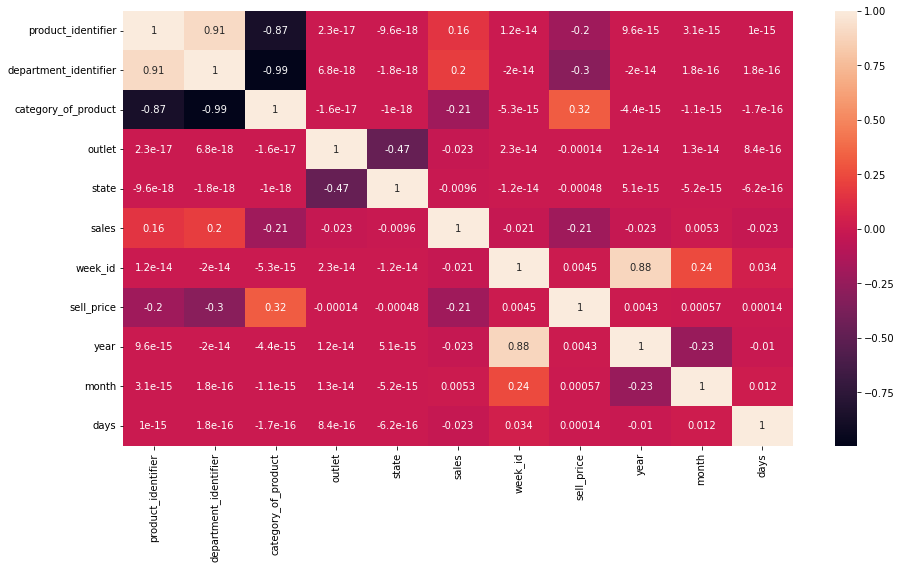

In [174]:
#checking for correlation
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(),annot=True)
plt.show()

### <center>we can observe high correlation from above heatmap and to cofirm that i am plotting the below curves to visualize</center>

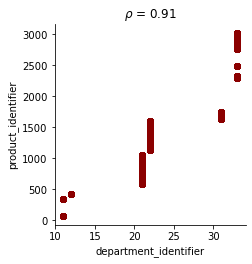

In [176]:
#Correlation between y and x
sns.PairGrid(df,y_vars='product_identifier',x_vars='department_identifier',height = 3.5).map(plt.scatter, color='darkred', alpha = 0.3)
coef = np.corrcoef(df['product_identifier'],df['department_identifier'])[0][1]
label = r'$\rho$ = ' + str(round(coef, 2))
plt.title(label)
plt.show()

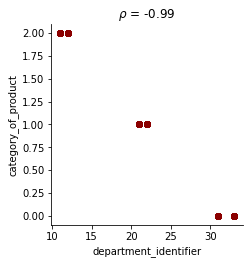

In [177]:
sns.PairGrid(df,y_vars='category_of_product',x_vars='department_identifier',height = 3.5).map(plt.scatter, color='darkred', alpha = 0.3)
coef = np.corrcoef(df['category_of_product'],df['department_identifier'])[0][1]
label = r'$\rho$ = ' + str(round(coef, 2))
plt.title(label)
plt.show()

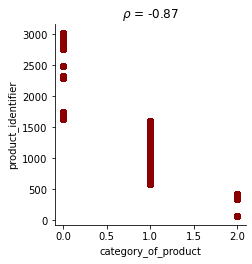

In [178]:
#Correlation between y and x
sns.PairGrid(df,y_vars='product_identifier',x_vars='category_of_product',height = 3.5).map(plt.scatter, color='darkred', alpha = 0.3)
coef = np.corrcoef(df['product_identifier'],df['category_of_product'])[0][1]
label = r'$\rho$ = ' + str(round(coef, 2))
plt.title(label)
plt.show()

# <center>checking for variance_inflation_factor
to be sure which column to drop to reduce the multicolinearity</center>

In [179]:
vif_df = df.loc[:, df.columns != 'price']

vif_data = pd.DataFrame()
vif_data["feature"] = vif_df.columns
vif_data["VIF"] = [variance_inflation_factor(vif_df.values ,i) for i in range(len(vif_df.columns))]
vif_data

,feature,VIF
0,product_identifier,95.297140
1,department_identifier,7197.046049
2,category_of_product,799.607489
3,outlet,8.155501
4,state,3.413824
5,sales,1.213867
6,week_id,12.179093
7,sell_price,3.102333
8,year,9370.445950
9,month,4.202893


In [180]:
df.drop('year',axis=1,inplace=True)

In [181]:
df.drop('department_identifier',axis=1,inplace=True)

In [182]:
vif_df = df.loc[:, df.columns != 'price']

vif_data = pd.DataFrame()
vif_data["feature"] = vif_df.columns
vif_data["VIF"] = [variance_inflation_factor(vif_df.values ,i) for i in range(len(vif_df.columns))]
vif_data

,feature,VIF
0,product_identifier,8.785285
1,category_of_product,5.961290
2,outlet,6.764535
3,state,3.029662
4,sales,1.184118
5,week_id,10.623553
6,sell_price,3.097272
7,month,4.146422
8,days,4.015274


In [183]:
df.head()

,product_identifier,category_of_product,outlet,state,sales,week_id,sell_price,month,days
0,74,2,111,1,0.0,49,2.94,1,1
1,337,2,111,1,1.0,49,7.44,1,1
2,423,2,111,1,0.0,49,0.97,1,1
3,432,2,111,1,0.0,49,4.97,1,1
4,581,1,111,1,0.0,49,4.88,1,1


In [184]:
df.shape

(395000, 9)

### <center>Train test split to train the model after dropping columns</center>

In [185]:
x = df.drop('sales',axis=1)
y = df['sales']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=42)
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,test_size=0.20,random_state=42)

In [186]:
df.head()

,product_identifier,category_of_product,outlet,state,sales,week_id,sell_price,month,days
0,74,2,111,1,0.0,49,2.94,1,1
1,337,2,111,1,1.0,49,7.44,1,1
2,423,2,111,1,0.0,49,0.97,1,1
3,432,2,111,1,0.0,49,4.97,1,1
4,581,1,111,1,0.0,49,4.88,1,1


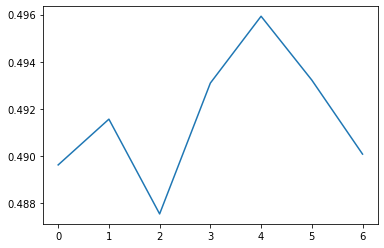

In [187]:
acc = []
for i in range(130,200,10):
    regr = RandomForestRegressor(n_estimators =i)
    regr.fit(x_train, y_train)
    acc.append(regr.score(x_cv,y_cv))
plt.plot(acc)

In [188]:
np.argmax(acc),acc[np.argmax(acc)]

(4, 0.4959314574131235)

In [189]:
x_train.columns

Index(['product_identifier', 'category_of_product', 'outlet', 'state',
       'week_id', 'sell_price', 'month', 'days'],
      dtype='object')

## <center>Training on entire dataset using best n_estimator for Random Forest regressor</center>

In [190]:
df_temp = df_dw.merge(df_pp, on = "week_id", how = "inner")
df=pd.merge(df_train, df_temp, on =['date','product_identifier','outlet'],how = "inner")

In [191]:
df.head()

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price
0,2012-01-01,74,11,others,111,Maharashtra,0,49,2.94
1,2012-01-01,337,11,others,111,Maharashtra,1,49,7.44
2,2012-01-01,423,12,others,111,Maharashtra,0,49,0.97
3,2012-01-01,432,12,others,111,Maharashtra,0,49,4.97
4,2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0,49,4.88


In [192]:
df['year'] = df['date'].apply(lambda x: int(x.split('-')[0]))
df['month'] = df['date'].apply(lambda x: int(x.split('-')[1]))
df['days'] = df['date'].apply(lambda x: int(x.split('-')[2]))
df.drop('date',axis=1,inplace=True)

labelencoder=LabelEncoder()

df['category_of_product']=labelencoder.fit_transform(df['category_of_product'])
df['state']=labelencoder.fit_transform(df['state'])

In [193]:
df.shape

(395000, 11)

In [194]:
df.head() 

,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price,year,month,days
0,74,11,2,111,1,0,49,2.94,2012,1,1
1,337,11,2,111,1,1,49,7.44,2012,1,1
2,423,12,2,111,1,0,49,0.97,2012,1,1
3,432,12,2,111,1,0,49,4.97,2012,1,1
4,581,21,1,111,1,0,49,4.88,2012,1,1


In [44]:
df.drop(['department_identifier','year','days'],axis=1,inplace=True)

In [45]:
df.columns

Index(['product_identifier', 'category_of_product', 'outlet', 'state', 'sales',
       'week_id', 'sell_price', 'month'],
      dtype='object')

In [197]:
x = df.drop('sales',axis=1)
y = df['sales']

In [198]:
#Again building the model
regr = RandomForestRegressor(n_estimators=180)
regr.fit(x, y)

RandomForestRegressor(n_estimators=180)

# <center>Getting Feature Importance</center>

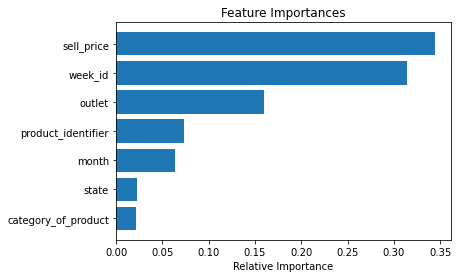

In [199]:
features = x_train.columns
importances = regr.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# <center>Predicting on Test dataset</center>

In [18]:
import pandas as pd
df_test = pd.read_csv('test_data.csv')

In [19]:
df_test.head()

,id,date,product_identifier,department_identifier,category_of_product,outlet,state
0,1,2014-03-01,74,11,others,111,Maharashtra
1,2,2014-03-01,337,11,others,111,Maharashtra
2,3,2014-03-01,423,12,others,111,Maharashtra
3,4,2014-03-01,432,12,others,111,Maharashtra
4,5,2014-03-01,581,21,fast_moving_consumer_goods,111,Maharashtra


In [20]:
df_temp = df_dw.merge(df_pp, on = "week_id", how = "inner")
df_test=pd.merge(df_test, df_temp, on =['date','product_identifier','outlet'],how = "inner")

In [21]:
df_test.head()

,id,date,product_identifier,department_identifier,category_of_product,outlet,state,week_id,sell_price
0,1,2014-03-01,74,11,others,111,Maharashtra,162,3.43
1,2,2014-03-01,337,11,others,111,Maharashtra,162,7.78
2,3,2014-03-01,423,12,others,111,Maharashtra,162,0.97
3,4,2014-03-01,432,12,others,111,Maharashtra,162,4.97
4,5,2014-03-01,581,21,fast_moving_consumer_goods,111,Maharashtra,162,4.88


In [22]:
df_test['month'] = df_test['date'].apply(lambda x: int(x.split('-')[1]))
df_test['days'] = df_test['date'].apply(lambda x: int(x.split('-')[2]))

In [23]:
df_t = df_test

In [24]:
df_test.drop(['id','date','department_identifier','days'],axis=1,inplace=True)

In [25]:
df_test.head()

,product_identifier,category_of_product,outlet,state,week_id,sell_price,month
0,74,others,111,Maharashtra,162,3.43,3
1,337,others,111,Maharashtra,162,7.78,3
2,423,others,111,Maharashtra,162,0.97,3
3,432,others,111,Maharashtra,162,4.97,3
4,581,fast_moving_consumer_goods,111,Maharashtra,162,4.88,3


In [27]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
df_test['category_of_product']=labelencoder.fit_transform(df_test['category_of_product'])
df_test['state']=labelencoder.fit_transform(df_test['state'])

In [28]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15500 entries, 0 to 15499
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_identifier   15500 non-null  int64  
 1   category_of_product  15500 non-null  int32  
 2   outlet               15500 non-null  int64  
 3   state                15500 non-null  int32  
 4   week_id              15500 non-null  int64  
 5   sell_price           15500 non-null  float64
 6   month                15500 non-null  int64  
dtypes: float64(1), int32(2), int64(4)
memory usage: 847.7 KB


In [29]:
import joblib
joblib.dump(regr, 'sooryar.pkl')

In [33]:
regr = joblib.load('sooryar.pkl')

In [30]:
df_test

,product_identifier,category_of_product,outlet,state,week_id,sell_price,month
0,74,2,111,1,162,3.43,3
1,337,2,111,1,162,7.78,3
2,423,2,111,1,162,0.97,3
3,432,2,111,1,162,4.97,3
4,581,1,111,1,162,4.88,3
...,...,...,...,...,...,...,...
15495,2932,0,333,0,166,2.78,3
15496,2935,0,333,0,166,0.20,3
15497,3004,0,333,0,166,2.68,3
15498,3008,0,333,0,166,1.98,3


In [34]:
f_pred = regr.predict(df_test)

In [35]:
f_pred

array([0.13806868, 0.74067798, 0.09888889, ..., 0.        , 1.27205845,
       0.00925926])

In [49]:
regr.score(x_train,y_train)

0.6006785659912768

In [50]:
regr.score(x_test,y_test)

0.5516323660113978

In [53]:
y_pred = regr.predict(x_test)

In [54]:
print('RMSE :',mean_squared_error(y_test, y_pred,squared=False))
print('r2 score: ', r2_score(y_test, y_pred))

RMSE : 2.2740119439437443
r2 score:  0.5516323660113978


In [219]:
#coverting the predictions to csv format
prediction=pd.DataFrame(f_pred,columns=['sales']).to_csv('predictions.csv')

In [220]:
df_test = pd.read_csv('test_data.csv')
newdf1=df_test['id']
newdf1.head()

0    1
1    2
2    3
3    4
4    5
Name: id, dtype: int64

In [221]:
newdf1.shape

(15500,)

In [222]:
newdf2=pd.DataFrame(f_pred)
newdf2.head()

,0
0,0.138069
1,0.740678
2,0.098889
3,0.000000
4,2.105015


In [223]:
newdf2.shape

(15500, 1)

In [224]:
prediction=pd.concat([newdf1,newdf2],axis=1)

In [225]:
prediction

,id,0
0,1,0.138069
1,2,0.740678
2,3,0.098889
3,4,0.000000
4,5,2.105015
...,...,...
15495,15496,1.472768
15496,15497,10.939006
15497,15498,0.000000
15498,15499,1.272058


In [226]:
prediction.to_csv('predicted_finals.csv',index=False)